<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

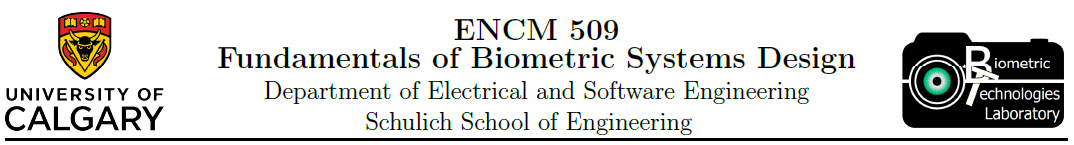

<center>
    <h1>Laboratory Experiment #4</h1>
    <h3>Fingerprint Biometrics - Part I: Preprocessing and Feature Extraction</h3>
</center>

# Lab 4 - Report 

#### UCID: 30085789
#### Name: Abhay Khosla

## Introduction
In this lab we will exploring image processing via using fingerprint images in .bmp(raw image format) and recognizing the fingerprint using the extracted features. This is a core part of biometric security systems and is used in many applications such as mobile phones, laptops, and other devices. The main goal of this lab is to understand the process of fingerprint recognition and to implement the feature extraction and matching algorithms. We utilized the DigitalPerson USB fingerprint reader to capture the fingerprint images. In this lab exercise we also learn the practical integration of of theoretical knowledge with the essential Python libraries, including the manual installation of OpenCV. This lab serves as a foundational step towards mastering biometric system design, emphasizing critical analysis and feature extraction expertise.

In [2]:
import cv2 as cv
import numpy as np

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, please open your Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

from scipy.signal.signaltools import wiener

from utils_encm.poincare import calculate_singularities
from utils_encm.segmentation import segmentation
from utils_encm.normalization import normalize
from utils_encm.gabor_filter import gabor_filter
from utils_encm.frequency import ridge_freq
from utils_encm.orientation import calculate_angles, visualize_angles
from utils_encm.crossing_number import calculate_minutiae
from utils_encm.skeletonize import skeletonize
from utils_encm.MatchGaborFeat import MatchGaborFeat
from utils_encm.align2 import align2
from utils_encm.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

C:\Users\abhay\AppData\Local\Temp\ipykernel_15572\1707584806.py:14: DeprecationWarning: Please use `wiener` from the `scipy.signal` namespace, the `scipy.signal.signaltools` namespace is deprecated.
  from scipy.signal.signaltools import wiener


0 255


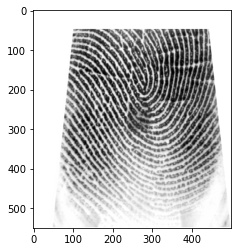

In [3]:
# is necessary to convert to uint to have the range 0-255
# some images might to return as 0-1
img = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))

# copying the original image in case to use later on
input_img = img.copy()

print(np.min(img), np.max(img))

plt.imshow(img)

### Preprocessing

#### Histogram Equalization

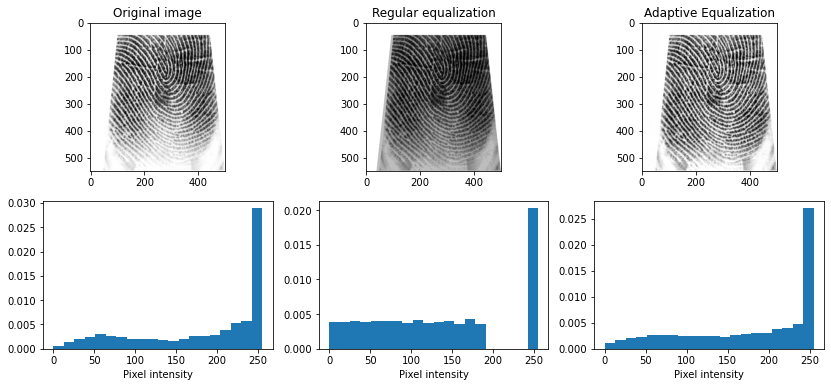

In [4]:
# equalize functions return a float adata 0-1
# to se as uint8 is necessary to convert
img_eq1 = img_as_ubyte(equalize_hist(img))
img_eq2 = img_as_ubyte(equalize_adapthist(img))

plt.figure(figsize=(14,6))
plt.subplot(2,3,1)
plt.imshow(img)
plt.title('Original image')
plt.subplot(2,3,2)
plt.imshow(img_eq1) 
plt.title('Regular equalization')
plt.subplot(2,3,3)
plt.imshow(img_eq2)
plt.title('Adaptive Equalization')
plt.subplot(2,3,4)
plt.hist(img.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,5)
plt.hist(img_eq1.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,6)
plt.hist(img_eq2.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')

#### De-noising

d:\Programs\anaconda\envs\laba\lib\site-packages\scipy\signal\signaltools.py:1611: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
d:\Programs\anaconda\envs\laba\lib\site-packages\scipy\signal\signaltools.py:1611: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


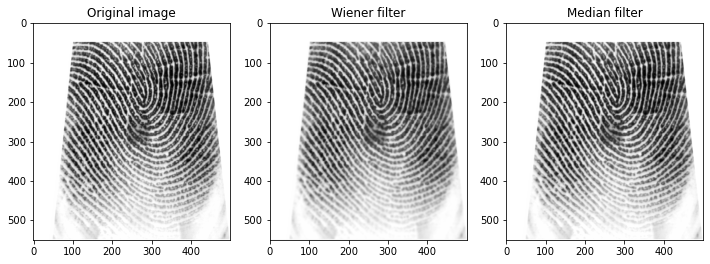

In [5]:
# two different denoising filters are applyed.
# you should chose one

# Wiener filter needs the input image as float (not uint8)
# the (5,5) corresponds to the sized of the window to considered during the processing.
img_wiener = wiener(img.astype('float'), (5,5))
# is necessary to convert the output back to uint8. 
# some additional steps are necessary to have it in 0-255. 
img_wiener = img_as_ubyte((img_wiener-np.min(img_wiener))/(np.max(img_wiener)-np.min(img_wiener)))

# with the Median filter is not necessary to convert back to uint8 
img_median = median(img)

plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Original image')
plt.subplot(1,3,2)
plt.imshow(img_wiener)
plt.title('Wiener filter')
plt.subplot(1,3,3)
plt.imshow(img_median)
plt.title('Median filter')

#### Parameters used for the next steps

In [6]:
# block size usend for windowed processing
block_size = 16

# for segmentation
threshold = 0.2

 ### Normalization

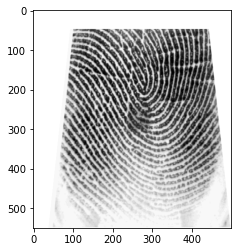

In [7]:
# normalization - removes the effects of sensor noise and finger pressure differences.
normalized_img = normalize(input_img.copy(), float(100), float(100))

plt.imshow(normalized_img)

### Segmentation

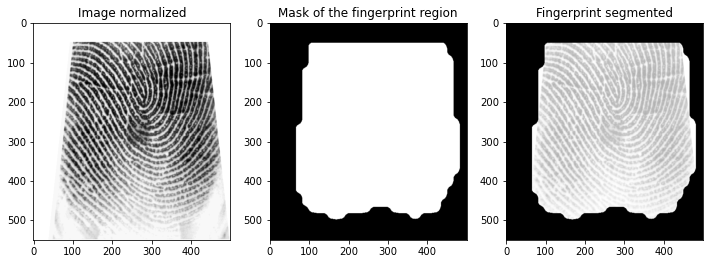

In [8]:
(segmented_img, normim, mask) = segmentation(normalized_img, block_size, threshold)

plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(normim)
plt.title('Image normalized')
plt.subplot(1,3,2)
plt.imshow(mask)
plt.title('Mask of the fingerprint region')
plt.subplot(1,3,3)
plt.imshow(segmented_img)
plt.title('Fingerprint segmented')

Text(0.5, 1.0, 'Fingerprint contour')

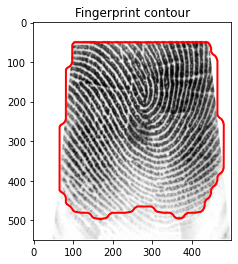

In [9]:
contours = find_contours(mask, 0.8)

plt.imshow(img)
for c in contours:
    plt.plot(c[:, 1], c[:, 0], linewidth=2, c='red')
plt.title('Fingerprint contour')

### Orientation Estimation

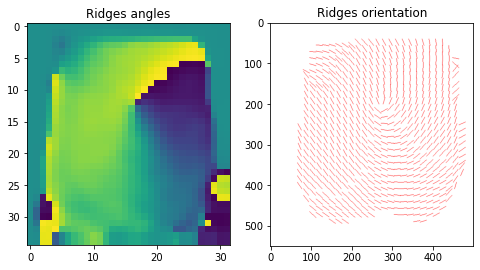

In [10]:
angles = calculate_angles(normalized_img, W=block_size, smooth=True)
orientation_img = visualize_angles(segmented_img, mask, angles, W=block_size)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(angles, cmap='viridis')
plt.title('Ridges angles')
plt.subplot(1,2,2)
plt.imshow(orientation_img)
plt.title('Ridges orientation')

### Ridges Frequency

In [11]:
# find the overall frequency of ridges
freq = ridge_freq(normim, mask, angles, block_size, kernel_size=5, minWaveLength=5, maxWaveLength=15)

### Gabor Filtering

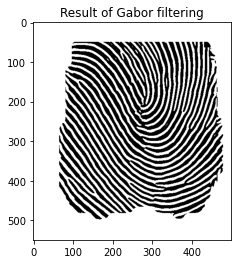

In [12]:
# create gabor filter and do the actual filtering
gabor_img = gabor_filter(normim, angles, freq, block_size2=block_size, kx=0.65, ky=0.65)

plt.imshow(gabor_img, cmap='gray')
plt.title('Result of Gabor filtering')

### Thinning or Skeletonize

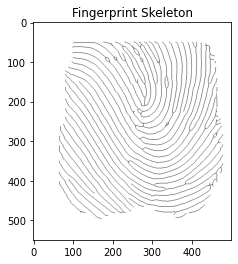

In [13]:
thin_image = skeletonize(gabor_img)

plt.imshow(thin_image, cmap='gray')
plt.title('Fingerprint Skeleton')

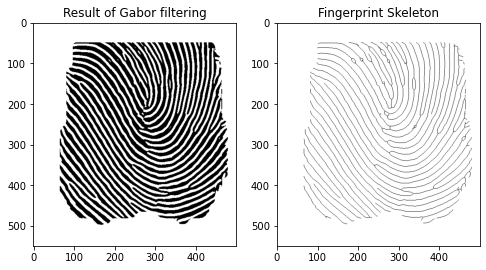

In [14]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(gabor_img, cmap='gray')
plt.title('Result of Gabor filtering')
plt.subplot(1,2,2)
plt.imshow(thin_image, cmap='gray')
plt.title('Fingerprint Skeleton')

### Minutiae

Total of minutiae detected: 50


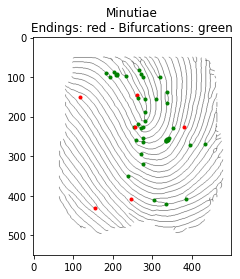

In [15]:
# minutiae_lst is a list with all minutiae coordinates and its type: 
# bifurcation or ending.
# minutiae_img is an image of the minutiae already plot on top of the skeleton
minutiae_lst, minutiae_img, _ = calculate_minutiae(thin_image, mask)

plt.imshow(thin_image)

for p in minutiae_lst:
    x,y = p[0], p[1]
    color = 'red' if p[2] == 'ending' else 'green'
    plt.plot(x,y, color, marker='.')

plt.title('Minutiae\nEndings: red - Bifurcations: green')
print('Total of minutiae detected: %d' % (len(minutiae_lst)))

Total of singularities detected: 4


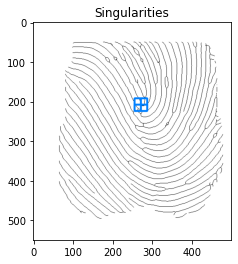

In [16]:
# singularities: whorl, loop and delta.
singularities_lst, singularities_img = calculate_singularities(thin_image, angles, block_size, mask)

plt.imshow(singularities_img)
plt.title('Singularities')
print('Total of singularities detected: %d' % (len(singularities_lst)))

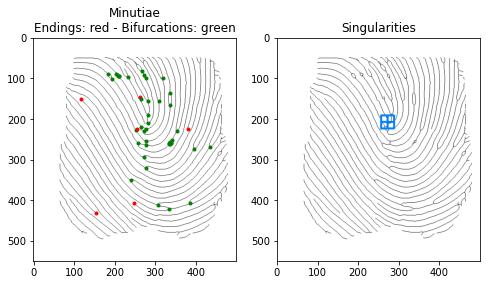

In [17]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(thin_image)
for p in minutiae_lst:
    x,y = p[0], p[1]
    color = 'red' if p[2] == 'ending' else 'green'
    plt.plot(x,y, color, marker='.')
plt.title('Minutiae\nEndings: red - Bifurcations: green')
plt.subplot(1,2,2)
plt.imshow(singularities_img)
plt.title('Singularities')

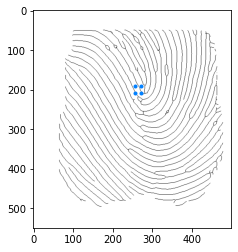

In [18]:
plt.imshow(thin_image)

for p in singularities_lst:
    x,y = p[0], p[1]
    
    # color is defined according to the singularity
    if (p[2] == 'loop'):
        color = 'blue'
    elif (p[2] == 'delta'):
        color = (0, 0.5, 1)
    elif (p[2] == 'whorl'):
        color = (1, 0.6, 1)
        
    plt.plot(x,y, c=color, marker='.')

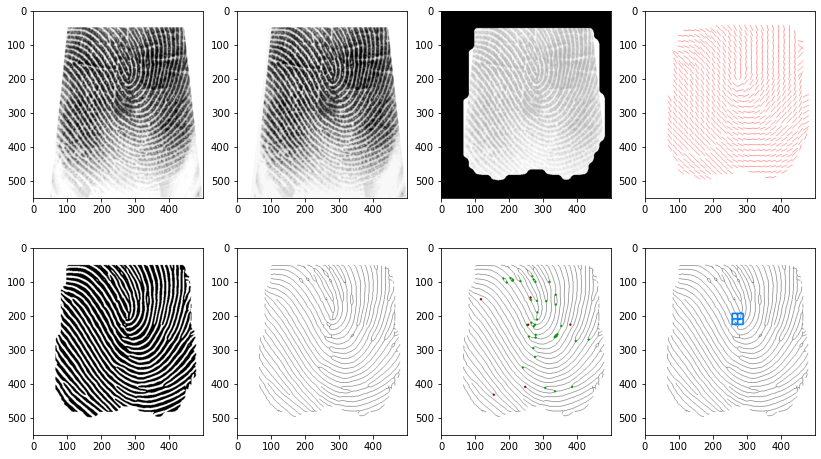

In [19]:
plt.figure(figsize=(14,8))
plt.subplot(2,4,1)
plt.imshow(input_img, cmap='gray')
plt.subplot(2,4,2)
plt.imshow(normalized_img, cmap='gray')
plt.subplot(2,4,3)
plt.imshow(segmented_img, cmap='gray')
plt.subplot(2,4,4)
plt.imshow(orientation_img)
plt.subplot(2,4,5)
plt.imshow(gabor_img, cmap='gray')
plt.subplot(2,4,6)
plt.imshow(thin_image, cmap='gray')
plt.subplot(2,4,7)
plt.imshow(minutiae_img)
plt.subplot(2,4,8)
plt.imshow(singularities_img)

### All the steps above compiled in one function

In [5]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

## Matching

##### Loading and processing

In [21]:
# loading two images for Minutiae extraction and matching
im1 = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/1.bmp', as_gray=True))
im2 = img_as_ubyte(imread('BTLab_Fingerprints/right_thumb/2.bmp', as_gray=True))

# parameters for processing
seg_threshold = 0.4
block_size = 16

# processing
Fp1 = fingerprint_processing(im1, block_size=block_size, threshold=seg_threshold)
Fp2 = fingerprint_processing(im2, block_size=block_size, threshold=seg_threshold)

Total of minutiae detected: 47
Total of singularities detected: 4
Total of minutiae detected: 84
Total of singularities detected: 4


##### Score based on Minutiae

In [22]:
# NOTE: this processing will take some time (about 20min). Go to get some coffee/tea :)

# Align the two fingerprints for better matching
imSkeletonAlign, minutiaArrayAlign = align2(Fp1, Fp2)
Fp2['imSkeletonAlign'] = imSkeletonAlign
Fp2['minutiaArrayAlign'] = minutiaArrayAlign

match_threshold = 6
score = match(Fp1, Fp2, threshold2=match_threshold)
print('score for minutiae: %.4f\n' % (score))

number of matched minutiae: 3
distance total computed : 11
number of minutiae in input image: 748
number of minutiae in database image: 64
score for minutiae: 0.0074



#### Score based on Gabor features

In [23]:
score2 = MatchGaborFeat(im1, im2)
print('Score using Gabor features: %.4f' % (score2))

Score using Gabor features: 13.0024


## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
2. (10 marks) Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section).
3. Conclusion (a paragraph on what is the main take-out of the lab).

**PART I (Lab 4): Specific Questions** 

A detailed description of each exercise to be included in your report (10 marks total) is given below:

**Exercise 1** (3 marks): Select **two fingerprints of different quality (one good and one bad one) from two different fingers each (4 in total)**. Modify the Lab notebook (`Lab04-Fingerprint1.ipynb`) by adding the **histogram equalization** step. For each fingerprint, perform all the pre-processing, and then add the histogram equalization. Compare the quantity of minutiae and singularities detected WITHOUT and WITH  the histogram equalization step. Record the number of minutiae, the number of singularities for each case. Draw the conclusions from this comparison.

##### Loading and processing-Exercise 1 Good/Bad Left Thumb Fingerprint

In [7]:
# Exercise 1 
# Load Images from the data collected during the lab 
image1GoodLeft = img_as_ubyte(imread('./Abhay Fingerprints/Left Thumb/10.bmp', as_gray=True)) # Converting the image to grayscale
image2BadLeft = img_as_ubyte(imread('./Abhay Fingerprints/Left Thumb/1.bmp', as_gray=True)) # Converting the image to grayscale

# Parameters for processing
seg_threshold = 0.4
block_size = 16

# Image processing
print('Processing good left thumb fingerprint without equalization')
Fp1ProcessingGoodLeft = fingerprint_processing(image1GoodLeft, block_size=block_size, threshold=seg_threshold)
print('Processing bad left thumb fingerprint without equalization')
Fp2ProcessingBadLeft = fingerprint_processing(image2BadLeft, block_size=block_size, threshold=seg_threshold)

# Equalization for contrast enhancement 
image1EqHistGoodLeft = img_as_ubyte(equalize_hist(image1GoodLeft))
image1EqAdaptGoodLeft = img_as_ubyte(equalize_adapthist(image1GoodLeft))

image2EqHistBadLeft = img_as_ubyte(equalize_hist(image2BadLeft))
image2EqAdaptBadLeft = img_as_ubyte(equalize_adapthist(image2BadLeft))

# Image processing after equalization
print('Processing good left thumb fingerprint with equalization adaption')
Fp3ProcessingGoodLeftEqualization = fingerprint_processing(image1EqAdaptGoodLeft, block_size=block_size, threshold=seg_threshold)

print('Processing bad left thumb fingerprint with equalization adaption')
Fp4ProcessingBadLeftEqualization = fingerprint_processing(image2EqAdaptBadLeft, block_size=block_size, threshold=seg_threshold)

Processing good left thumb fingerprint without equalization
Total of minutiae detected: 73
Total of singularities detected: 8
Processing bad left thumb fingerprint without equalization
Total of minutiae detected: 48
Total of singularities detected: 4
Processing good left thumb fingerprint with equalization adaption
Total of minutiae detected: 78
Total of singularities detected: 8
Processing bad left thumb fingerprint with equalization adaption
Total of minutiae detected: 43
Total of singularities detected: 4


##### Score based on Minutiae-Exercise 1 Good Left Thumb Fingerprint

In [6]:
# NOTE: this processing will take some time (about 20min). Go to get some coffee/tea :)

# Align the two fingerprints for better matching
imSkeletonAlign, minutiaArrayAlign = align2(Fp1ProcessingGoodLeft, Fp3ProcessingGoodLeftEqualization)
Fp3ProcessingGoodLeftEqualization['imSkeletonAlign'] = imSkeletonAlign
Fp3ProcessingGoodLeftEqualization['minutiaArrayAlign'] = minutiaArrayAlign

match_threshold = 6
scoreMatchingGoodLeft = match(Fp1ProcessingGoodLeft, Fp3ProcessingGoodLeftEqualization, threshold2=match_threshold)
print('Score for minutiae: %.4f\n' % (scoreMatchingGoodLeft))

number of matched minutiae: 75
distance total computed : 245
number of minutiae in input image: 713
number of minutiae in database image: 85
Score for minutiae: 0.1880



##### Score based on Gabor Features-Exercise 1 Good Left Thumb Fingerprint

In [5]:
scoreGaborGoodLeft = MatchGaborFeat(image1GoodLeft, image1EqAdaptGoodLeft)
print('Score using Gabor features: %.4f' % (scoreGaborGoodLeft))

Score using Gabor features: 5.9502


##### Score based on Minutiae-Exercise 1 Bad Left Thumb Fingerprint

In [4]:
# NOTE: this processing will take some time (about 20min). Go to get some coffee/tea :)

# Align the two fingerprints for better matching
imSkeletonAlign, minutiaArrayAlign = align2(Fp2ProcessingBadLeft, Fp4ProcessingBadLeftEqualization)
Fp4ProcessingBadLeftEqualization['imSkeletonAlign'] = imSkeletonAlign
Fp4ProcessingBadLeftEqualization['minutiaArrayAlign'] = minutiaArrayAlign

match_threshold = 6
scoreMatchingBadLeft = match(Fp2ProcessingBadLeft, Fp4ProcessingBadLeftEqualization, threshold2=match_threshold)
print('Score for minutiae: %.4f\n' % (scoreMatchingBadLeft))

number of matched minutiae: 32
distance total computed : 105
number of minutiae in input image: 401
number of minutiae in database image: 53
Score for minutiae: 0.1410



##### Score based on Gabor Features-Exercise 1 Bad Left Thumb Fingerprint

In [6]:
scoreGaborBadLeft = MatchGaborFeat(image2BadLeft, image2EqAdaptBadLeft)
print('Score using Gabor features: %.4f' % (scoreGaborBadLeft))

Score using Gabor features: 8.1035


##### Plotting the Good Left Thumb Fingerprint with Histogram Equalization and Images

Text(0.5, 0, 'Pixel intensity')

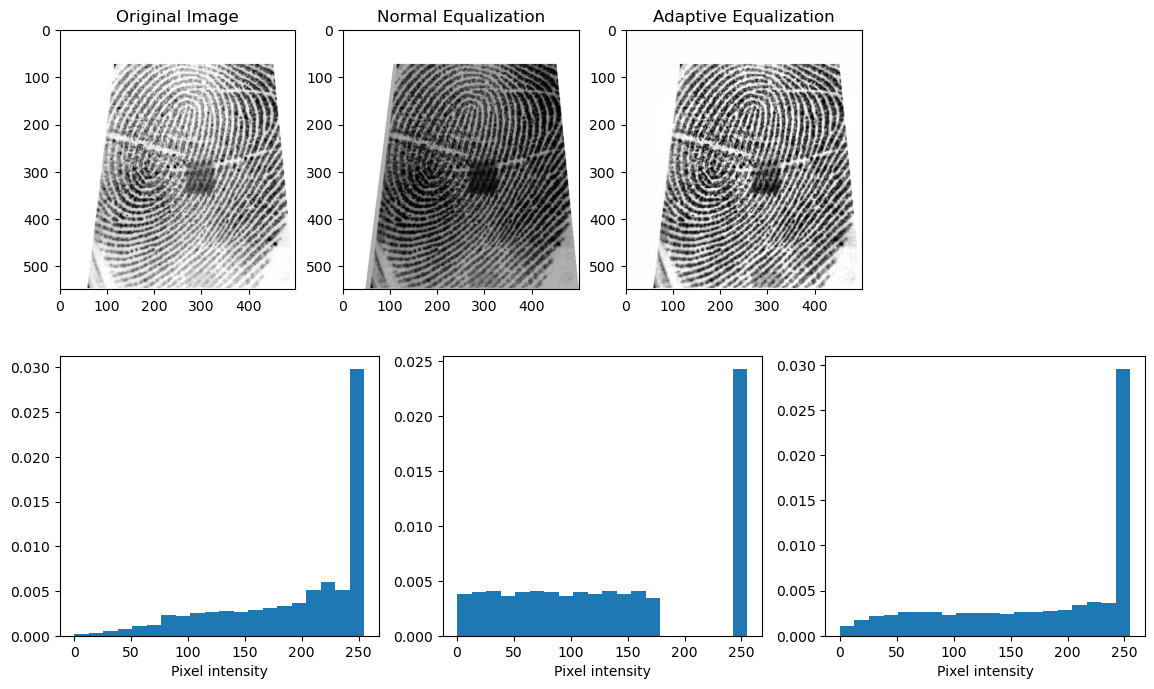

In [8]:
plt.figure(figsize=(14,8))
plt.subplot(2,4,1)
plt.imshow(image1GoodLeft, cmap='gray')
plt.title('Original Image')
plt.subplot(2,4,2)
plt.imshow(image1EqHistGoodLeft, cmap='gray')
plt.title('Normal Equalization')
plt.subplot(2,4,3)
plt.imshow(image1EqAdaptGoodLeft, cmap='gray')
plt.title('Adaptive Equalization')
plt.subplot(2,3,4)
plt.hist(image1GoodLeft.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,5)
plt.hist(image1EqHistGoodLeft.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,6)
plt.hist(image1EqAdaptGoodLeft.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')

##### Plotting the Bad Left Thumb Fingerprint with Histogram Equalization and Images

Text(0.5, 0, 'Pixel intensity')

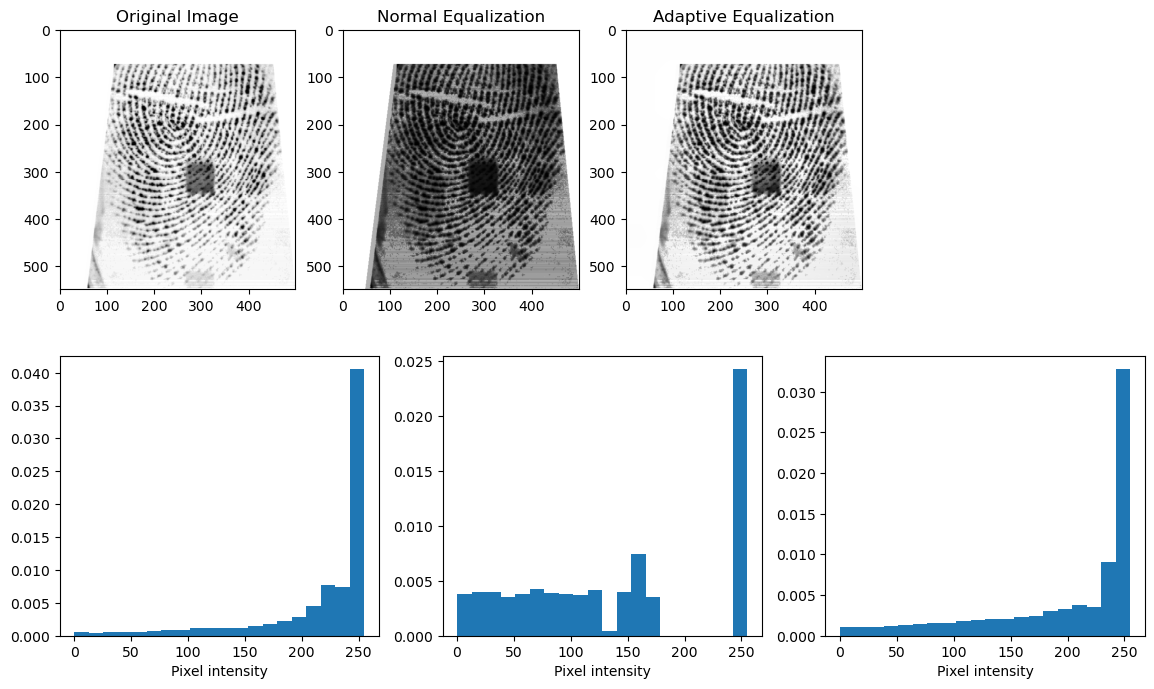

In [9]:
plt.figure(figsize=(14,8))
plt.subplot(2,4,1)
plt.imshow(image2BadLeft, cmap='gray')
plt.title('Original Image')
plt.subplot(2,4,2)
plt.imshow(image2EqHistBadLeft, cmap='gray')
plt.title('Normal Equalization')
plt.subplot(2,4,3)
plt.imshow(image2EqAdaptBadLeft, cmap='gray')
plt.title('Adaptive Equalization')
plt.subplot(2,3,4)
plt.hist(image2BadLeft.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,5)
plt.hist(image2EqHistBadLeft.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,6)
plt.hist(image2EqAdaptBadLeft.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')

##### Loading and processing-Exercise 1 Good/Bad Right Thumb Fingerprint

In [14]:
# Exercise 1 
# Load Images from the data collected during the lab 
image1GoodRight = img_as_ubyte(imread('./Abhay Fingerprints/Right Thumb/10.bmp', as_gray=True)) # Converting the image to grayscale
image2BadRight = img_as_ubyte(imread('./Abhay Fingerprints/Right Thumb/3.bmp', as_gray=True)) # Converting the image to grayscale

# Parameters for processing
seg_threshold = 0.4
block_size = 16

# Image processing
print('Processing good left thumb fingerprint without equalization')
Fp1ProcessingGoodRight = fingerprint_processing(image1GoodRight, block_size=block_size, threshold=seg_threshold)
print('Processing bad left thumb fingerprint without equalization')
Fp2ProcessingBadRight = fingerprint_processing(image2BadRight, block_size=block_size, threshold=seg_threshold)

# Equalization for contrast enhancement 
image1EqHistGoodRight = img_as_ubyte(equalize_hist(image1GoodRight))
image1EqAdaptGoodRight = img_as_ubyte(equalize_adapthist(image1GoodRight))

image2EqHistBadRight = img_as_ubyte(equalize_hist(image2BadRight))
image2EqAdaptBadRight = img_as_ubyte(equalize_adapthist(image2BadRight))

# Image processing after equalization
print('Processing good left thumb fingerprint with equalization adaption')
Fp3ProcessingGoodRightEqualization = fingerprint_processing(image1EqAdaptGoodRight, block_size=block_size, threshold=seg_threshold)

print('Processing bad left thumb fingerprint with equalization adaption')
Fp4ProcessingBadRightEqualization = fingerprint_processing(image2EqAdaptBadRight, block_size=block_size, threshold=seg_threshold)

Processing good left thumb fingerprint without equalization
Total of minutiae detected: 82
Total of singularities detected: 4
Processing bad left thumb fingerprint without equalization
Total of minutiae detected: 45
Total of singularities detected: 0
Processing good left thumb fingerprint with equalization adaption
Total of minutiae detected: 87
Total of singularities detected: 4
Processing bad left thumb fingerprint with equalization adaption
Total of minutiae detected: 108
Total of singularities detected: 0


##### Score based on Minutiae-Exercise 1 Good Right Thumb Fingerprint

In [11]:
# NOTE: this processing will take some time (about 20min). Go to get some coffee/tea :)

# Align the two fingerprints for better matching
imSkeletonAlign, minutiaArrayAlign = align2(Fp1ProcessingGoodRight, Fp3ProcessingGoodRightEqualization)
Fp3ProcessingGoodRightEqualization['imSkeletonAlign'] = imSkeletonAlign
Fp3ProcessingGoodRightEqualization['minutiaArrayAlign'] = minutiaArrayAlign

match_threshold = 6
scoreMatchingGoodRight = match(Fp1ProcessingGoodRight, Fp3ProcessingGoodRightEqualization, threshold2=match_threshold)
print('Score for minutiae: %.4f\n' % (scoreMatchingGoodRight))

number of matched minutiae: 74
distance total computed : 264
number of minutiae in input image: 814
number of minutiae in database image: 90
Score for minutiae: 0.1637



##### Score based on Gabor Features-Exercise 1 Good Left Thumb Fingerprint

In [12]:
scoreGaborGoodLeft = MatchGaborFeat(image1GoodRight, image1EqAdaptGoodRight)
print('Score using Gabor features: %.4f' % (scoreGaborGoodLeft))

Score using Gabor features: 6.7691


##### Score based on Minutiae-Exercise 1 Bad Right Thumb Fingerprint

In [19]:
# NOTE: this processing will take some time (about 20min). Go to get some coffee/tea :)

# Align the two fingerprints for better matching
imSkeletonAlign, minutiaArrayAlign = align2(Fp2ProcessingBadRight, Fp4ProcessingBadRightEqualization)
Fp4ProcessingBadRightEqualization['imSkeletonAlign'] = imSkeletonAlign
Fp4ProcessingBadRightEqualization['minutiaArrayAlign'] = minutiaArrayAlign

match_threshold = 6
scoreMatchingBadRight = match(Fp2ProcessingBadRight, Fp4ProcessingBadRightEqualization, threshold2=match_threshold)
print('Score for minutiae: %.4f\n' % (scoreMatchingBadRight))

number of matched minutiae: 0
distance total computed : 0
number of minutiae in input image: 0
number of minutiae in database image: 45
Score for minutiae: 0.0000



##### Score based on Gabor Features-Exercise 1 Bad Right Thumb Fingerprint

In [16]:
scoreGaborBadRight = MatchGaborFeat(image2BadRight, image2EqAdaptBadRight)
print('Score using Gabor features: %.4f' % (scoreGaborBadRight))

Score using Gabor features: 8.8097


##### Plotting the Good Right Thumb Fingerprint with Histogram Equalization and Images

Text(0.5, 0, 'Pixel intensity')

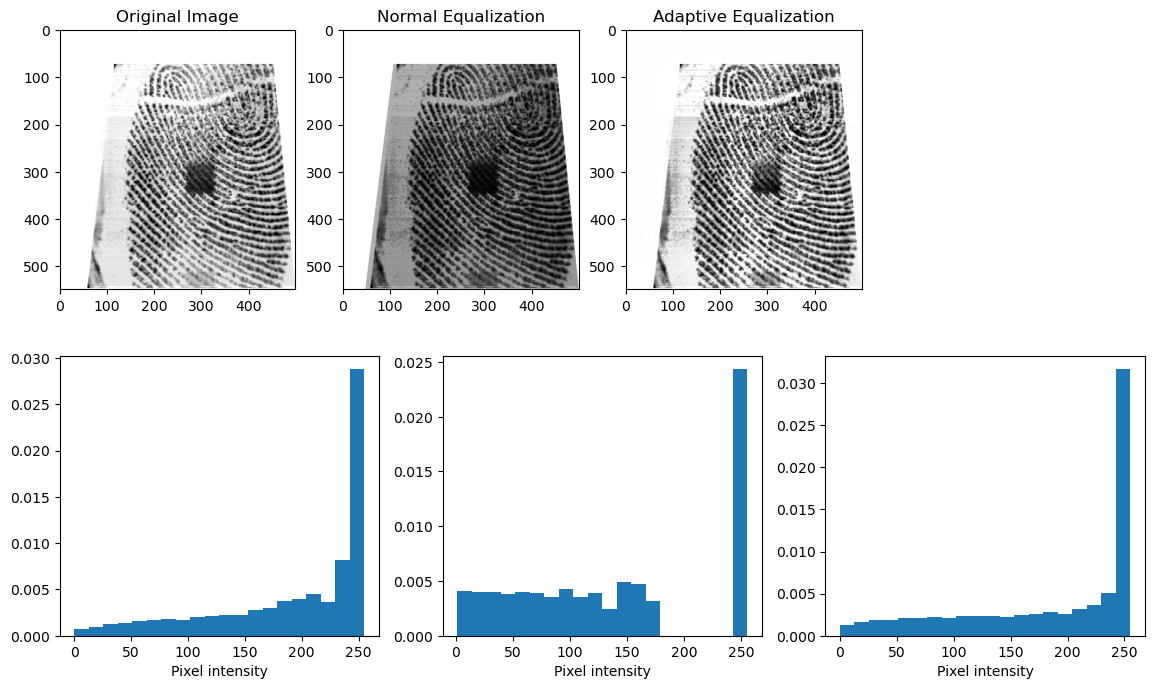

In [17]:
plt.figure(figsize=(14,8))
plt.subplot(2,4,1)
plt.imshow(image1GoodRight, cmap='gray')
plt.title('Original Image')
plt.subplot(2,4,2)
plt.imshow(image1EqHistGoodRight, cmap='gray')
plt.title('Normal Equalization')
plt.subplot(2,4,3)
plt.imshow(image1EqAdaptGoodRight, cmap='gray')
plt.title('Adaptive Equalization')
plt.subplot(2,3,4)
plt.hist(image1GoodRight.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,5)
plt.hist(image1EqHistGoodRight.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,6)
plt.hist(image1EqAdaptGoodRight.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')

##### Plotting the Bad Right Thumb Fingerprint with Histogram Equalization and Images

Text(0.5, 0, 'Pixel intensity')

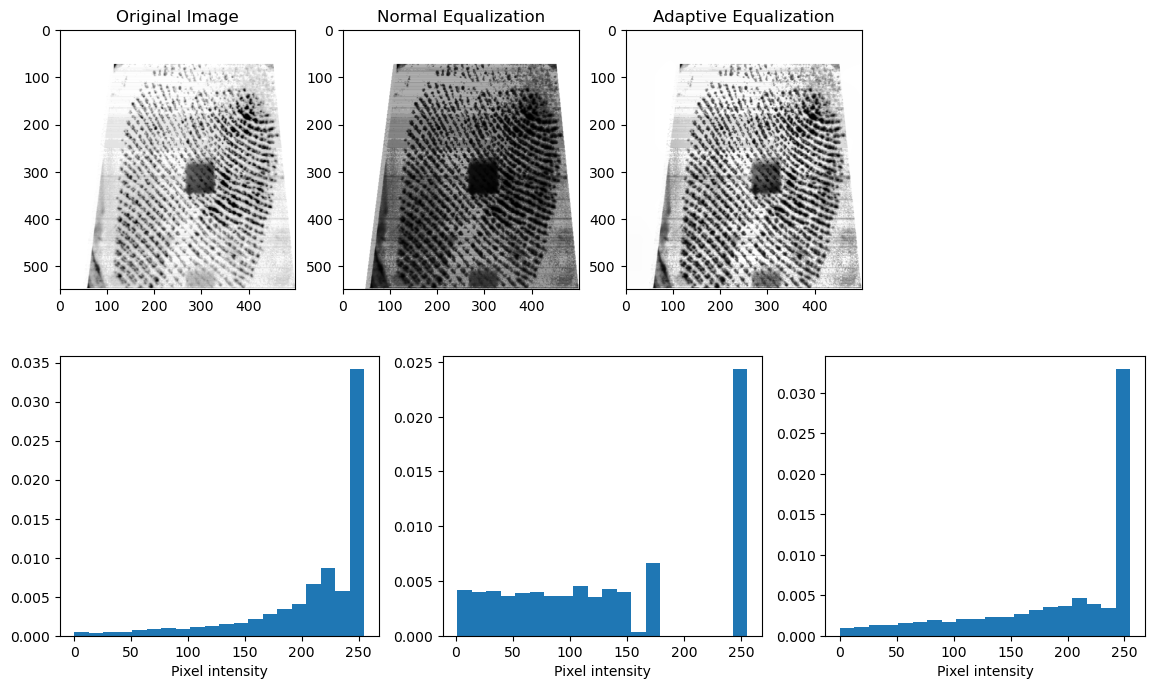

In [18]:
plt.figure(figsize=(14,8))
plt.subplot(2,4,1)
plt.imshow(image2BadRight, cmap='gray')
plt.title('Original Image')
plt.subplot(2,4,2)
plt.imshow(image2EqHistBadRight, cmap='gray')
plt.title('Normal Equalization')
plt.subplot(2,4,3)
plt.imshow(image2EqAdaptBadRight, cmap='gray')
plt.title('Adaptive Equalization')
plt.subplot(2,3,4)
plt.hist(image2BadRight.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,5)
plt.hist(image2EqHistBadRight.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')
plt.subplot(2,3,6)
plt.hist(image2EqAdaptBadRight.ravel(), bins=20, density=True)
plt.xlabel('Pixel intensity')

##### Number of minutiae and singularities detected WITHOUT the histogram equalization step-Left Thumb Fingerprint
| Condition |      Minutiae     |  Singularities |
|----------|:-------------:|------:|
| Good  |  73 | 8 |
| Bad |    48  |   4 |


##### Number of minutiae and singularities detected WITH the histogram equalization step-Left Thumb Fingerprint
| Condition |      Minutiae     |  Singularities |
|----------|:-------------:|------:|
| Good  |  78 | 8 |
| Bad |    43  |   4 |


##### Number of minutiae and singularities detected WITHOUT the histogram equalization step-Right Thumb Fingerprint
| Condition |      Minutiae     |  Singularities |
|----------|:-------------:|------:|
| Good  |  82 | 4 |
| Bad |    45  |   0 |



##### Number of minutiae and singularities detected WITH the histogram equalization step-Right Thumb Fingerprint
| Condition |      Minutiae     |  Singularities |
|----------|:-------------:|------:|
| Good  |  87 | 4 |
| Bad |    108  |   0 |

#### Comparison of the quantity of minutiae and singularities detected WITHOUT and WITH the histogram equalization step
The data that is presented above in the has some variance in the number of minutiae and singularities detected in fingerprints with and without the histogram equalization step. Usually a higher count of minutiae indicates that it increases the uniqueness and the accuracy of identification. For the left thumb fingerprint in good condition, histogram equalization slightly improves minutiae detection but does not affect the singularity detection. For the left thumb fingerprint in bad condition, histogram equalization slightly decreases the minutiae detection which could indicate that over processing could be happening for the singularity detection count is same as also noticed in the left thumb good condition. The right thumb fingerprint in good condition shows a slight increase in minutiae detection and no change in singularity detection. The right thumb fingerprint in bad condition shows a significant increase in minutiae detection and no change in singularity detection. The increase in minutiae detection in the right thumb fingerprint in bad condition could be due to the over processing of the image that there were false minutiae detected or noise in the image that was detected as minutiae. This means that we need more careful parameter choosing for tuning and validation when using histogram equalization to ensure the enhancement process does not introduce artifacts or noise in the image.   

**Exercise 2** (3 marks): In this Exercise, perform the same steps as in exercise 1, but instead of histogram equalization, choose one **de-noising** method such as *Wiener* or *Median* filter. Modify the Lab notebook (`Lab04-Fingerprint1.ipynb`) accordingly, record the outcomes and draw the conclusions. 

- **Exercise 3** (4 marks): In this exercise, perform the same steps as in Exercise 1, but consider the **parameters `block_size` and `threshold`**. Evaluate the impact of these parameters by changing each of them to another value one at a time, for example: **change the `block_size` to 10 (`block_size = 10`) and keep the `threshold = 0.4`** (default). Second, **change the threshold only to `threshold = 0.5` while keeping the `block_size = 16`** (default). Evaluate  the number  of the detected minutiae and singularities. Compare the results and draw the conclusions.  